In [1]:
# This hidden cell is used for local execution of the notebook file, it does not appear in the published book

# Setup working directory
import os, re

dir_match = re.search(
    r".+ons-spark$",
    str(os.getcwd())
)

if not dir_match: os.chdir('../../..')

# Setup Spark environment variables for local use
import findspark
findspark.init()

## Spark Application and UI

This article introduces the structure of a Spark application and how the structure relates to the various pages within the application monitoring interface, the Spark UI. 

The Spark UI is used to monitor the status and resource consumption of your Spark cluster and is the main tool for troubleshooting slow Spark code. 

Understanding the structure of a Spark application helps to understand how Spark works so you can begin to think differently as you code to get the most out of Spark.

### Spark Application Overview
A Spark application has an underlining structure and learning about this structure will help us:
1. understand the difference between a narrow transformation, wide transformation and an action 
2. navigate around the Spark UI

Below is a diagram of the Spark application hierarchy:

- **Application** - a set of jobs managed by a single driver, e.g. on a Cloudera platform that is the CDSW session. An application is created when we connect to Spark with a [`SparkSession`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.SparkSession.html) in PySpark or [`spark_connect()`](https://spark.rstudio.com/packages/sparklyr/latest/reference/spark-connections.html) in sparklyr.
- **Job** - a set of stages executed as a result of an *action*, e.g. [`.count()`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.count.html)/[`sdf_nrow()`](https://spark.rstudio.com/packages/sparklyr/latest/reference/sdf_dim.html). A job might consist of a number of *transformations*, but a job always finishes with an *action*.
- **Stage** - a set of tasks that can be executed in parallel. Similar to how *actions* define a job boundary, a stage boundary is introduced by a *wide* transformation, such as [`.groupBy()`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.groupBy.html)/[`group_by()`](https://dplyr.tidyverse.org/reference/group_by.html) or [`.join()`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.join.html)/[`left_join()`](https://spark.rstudio.com/packages/sparklyr/latest/reference/join.tbl_spark.html). A stage might consist of many *narrow* transformations, but a stage always finishes with a *wide* transformation or action.
- **Task** - an individual unit of work assigned to a single core on an executor.

```{figure} ../images/spark_app_diagram.png
---
width: 100%
name: SparkApplication
alt: Diagram representing Spark application showing partitioned DataFrame going through narrow and wide operations
---
Spark application
```

Note that Jobs, Stages and Tasks are numbered starting from zero.

Now look more closely at the DataFrame. On the left there is a Spark DataFrame which is split up into four sections, called *partitions*. Spark puts our data into partitions automatically so we don't have to decide how or when to do it. More details on exactly how Spark does this are in the [Partitions Article](../spark-concepts/partitions).

The first operation to be applied to this DataFrame is a *narrow* transformation, e.g. adding two columns to create a new column. The second operation is again a narrow transformation. These two operations can be run in parallel, because each child partition has only one parent, indicated by the golden arrows.

Then we hit a stage boundary, which means the third operation is a *wide* transformation, e.g. aggregating the data or joining with another DataFrame. This is a wide operation because each child partition has multiple parent partitions. This is also an example of *shuffling* the data, which means to move data between partitions, more on shuffling in the [Shuffling Article](../spark-concepts/shuffling).

Finally in the diagram above there is another narrow operation on the aggregated DataFrame before we run into an *action*, e.g. writing the data to HDFS or a simple count of the rows. 

As we execute the wide and narrow transformations nothing happens to the data at this point in time, Spark just builds up a plan of what to do with the DataFrame. This plan is a called the execution plan and is a set of instructions of how to transform the data from one state to another. More on the execution plan in the [Persisting Article](../spark-concepts/persistence). An action initiates the execution plan and so this is when the DataFrame is processed. All the previous transformations, along with the action, are put into Spark *jobs* and deployed on the Spark cluster. 

### Investigate the Spark UI

We will create an application and execute some code to create jobs. Then we can drill down from Job to Stage to Task and investigate their performance. In most cases this is where we look first when trying to diagnose a slow Spark application.

#### Create an application

The first step is to create an application. Once we create a Spark application we can look at the Spark UI. If we stop the Spark session using [`spark.stop()`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.SparkSession.stop.html)/[`spark_disconnect()`](https://spark.rstudio.com/packages/sparklyr/latest/reference/spark-connections.html) or disconnect from the notebook, the Spark UI for our application can no longer be accessed.

Let's start with the necessary imports and create an application. 

In [2]:
import os, IPython
import yaml
from pyspark.sql import SparkSession, functions as F

spark = SparkSession.builder.master("local").appName("spark-app-ui").getOrCreate()

```r
library(sparklyr)

default_config <- sparklyr::spark_config()

sc <- sparklyr::spark_connect(
    master = "local",
    app_name = "spark-app-ui",
    config = default_config)
```

We can then look at the Spark UI using the URL  http://localhost:4040/jobs/. Note this address is used for a local Spark session, for more information on how to navigate to the Spark UI see the [documentation on monitoring](https://spark.apache.org/docs/latest/monitoring.html).

If you are running the source notebook and follow the above link you will see something similar to the screenshot below, with the application name on the top right and various tabs along the top. 

There is a lot of useful information in the Spark UI, but in this article we will only concentrate on the *Jobs* and *Stages* tabs. Note that we haven't executed any *Jobs* yet, so there isn't much to see at the moment.

```{figure} ../images/spark_app_empty_ui.png
---
width: 100%
name: EmptyUI
alt: Empty Spark UI page
---
Empty Spark UI page
```

Let's import the animal rescue data and find out the number of partitions in which our `rescue` DataFrame is processed. The number of partitions will be useful later when we're investigating our application's tasks.

In [3]:
with open("config.yaml") as f:
    config = yaml.safe_load(f)
    
rescue_path = config["rescue_path"]
rescue = spark.read.parquet(rescue_path)

print("Number of partitions: ",rescue.rdd.getNumPartitions())

Number of partitions:  1


```r
config <- yaml::yaml.load_file("config.yaml")

rescue <- sparklyr::spark_read_parquet(sc, config$rescue_path)

print(paste0("Number of partitions: ", sparklyr::sdf_num_partitions(rescue)))
```

Next we'll carry out some basic processes to see how this translates into jobs, stages and tasks in the Spark UI. We will  group the incident costs by creating a new column called `cost_group` containing three groups `small`, `medium` and `large`.

In [4]:
rescue = (
    rescue.withColumn("cost_group",
                      F.when(F.col("total_cost")<300, "small")
                      .when((F.col("total_cost")>=300) & (F.col("total_cost")<900), "medium")
                      .when(F.col("total_cost")>=1000, "large")
                      .otherwise(None)
                     )
)

rescue.select("animal_group", "description", "total_cost", "cost_group").show(7, truncate=80)

+------------+----------------------------------------------------------------+----------+----------+
|animal_group|                                                     description|total_cost|cost_group|
+------------+----------------------------------------------------------------+----------+----------+
|         Cat|                                         CAT TRAPPED IN BASEMENT|     290.0|     small|
|       Horse|                                           HORSE TRAPPED IN GATE|     590.0|    medium|
|        Bird|PIGEON WITH WING IMAPLED ON SHARP IMPLEMENT  UNDER A BRIDGE NEAR|     326.0|    medium|
|         Cat|                          ASSIST RSPCA WITH CAT STUCK ON CHIMNEY|     295.0|     small|
|         Dog|                                       DOG FALLEN INTO THE CANAL|     260.0|     small|
|        Deer|                                          DEER STUCK IN RAILINGS|     520.0|    medium|
|        Deer|                                           DEER TRAPPED IN FENCE|   

```r
rescue <- rescue %>% sparklyr::mutate(
    cost_group=dplyr::case_when(total_cost<300 ~ "small",
                                total_cost>=300 & total_cost<900 ~ "medium",
                                total_cost>=900 ~ "large",
                                TRUE ~ NULL)
)


rescue %>% 
    sparklyr::select("animal_group", "description", "total_cost", "cost_group") %>%
    head(7) %>%
    sparklyr::collect()
```

To produce the above output Spark didn't need to process all of the partitions, there are enough rows on one partition to create the output so Spark only processed one partition. If we want Spark to process all of the partitions we need to call an action that involves all rows of the DataFrame, such as getting the row count.

In [5]:
rescue.count()

5898

```r
rescue %>% sparklyr::sdf_nrow()
```

### Jobs page
Now that we've created some jobs let's have a quick look at the application's *Event timeline*. For those who are running this as a notebook:

1. Go into the Spark UI
2. Make sure you're on the Jobs tab
3. Open the *Event timeline* collapsible section using the blue arrow to see something similar to the below image.

Note the images in this article were created using PySpark, the Spark UI will look slightly different when using sparklyr, but not very different.

In the top section of the timeline you will see the executors being added and removed by the *dynamic allocation* feature of Spark. The `SparkSession` used in this case was a local session, so we will only see the driver here. The jobs are shown in the bottom section of the timeline. Hover over a job in the timeline and the corresponding job in the *Completed Jobs* table below will be highlighted.

*Tip:* You can tick the *Enable Zooming* button to zoom in and out of different sections of the timeline

```{figure} ../images/spark_app_event_timeline.png
---
width: 100%
name: AppEventTimeline
alt: Event timeline within Spark UI showing executors being assigned and jobs being deployed
---
An application's Event Timeline
```

Let's look at the *Completed Jobs* table. The description gives us a clue as to the action that initiated that job. The first job, *Job Id* 0, was to interact with HDFS, so it has the description `parquet at NativeMethodAccessorImpl.java:0`. Remember that executing transformations creates an execution plan, so Spark needs to know the DataFrame's schema, i.e. column names and types, to validate our PySpark/sparklyr code. Reading from disk will always create a job, usually consisting of just one stage as shown in the *Stages* column.

The second job was initiated by [`.show()`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.show.html)/[`collect()`](https://dplyr.tidyverse.org/reference/compute.html), again it consists of one stage, which itself had one task as shown in the *Tasks* column. As mentioned in the previous section, Spark only needed to process one partition to produce the output so we therefore have one task in this job. 

The third job was the `.count()`/`sdf_nrow()`. The job contains two stages, which themselves consist of 3 tasks. Let's get more information on these stages and tasks. Within the *Completed Jobs* table click on the link in the *Description* column for the latest job that says `count at NativeMethodAccessorImpl.java:0`. 

Now we are on the *Job Details* page which show information about the job's stages. The first stage had two tasks, one task to count the rows in each partition. The second stage had one task, which was to send the result to the driver for us to see. On this page you will see another type of diagram called a Directed Acyclic Graph or DAG, by opening the *DAG Vizualisation* collapsible section.

The DAG shows the two stages. Here are some rough definitions of the terms inside the boxes
1. *WholeStageCodegen*- this is Spark creating an optimised version of our code
2. *Exchange* - another word for *shuffling* data, i.e. data is being moved between partitions
3. *mapPartitionsInternal* - bringing information from multiple partitions together

There are more informative DAG diagrams on the SQL tab, which are explored in the [Optimising Joins](../spark-concepts/join-concepts) and [Persisting](../spark-concepts/persistence) articles. 

```{figure} ../images/spark_app_stages.png
---
width: 100%
name: JobDetails
alt: Job details page in Spark UI showing DAG diagram and table of the job's stages
---
Job details page
```

### Stages page

From the *Completed Stages* table on the *Job Details* page, when we click on the link in the *Description* column for the stage consisting of two tasks (*Stage Id* 2 in the example above), we get to the *Stage Details*. 

This page contains lots of detailed information about the individual tasks and it's one of the more useful places to look for troubleshooting sluggish applications. We will just concentrate on two sections within this page, the *Event timeline* (for tasks) and the *Summary Metrics*.

#### Task Event timeline

Opening the *Event timeline* collapsible menu will show a timeline like in the below image. This timeline has a single row, which means one executor (i.e. the driver in our case because we're running a local session) was used to complete these tasks. This executor has two cores, we know this because the *Executor Computing Time* (shown in green) of the two task are overlapping. If there was just one core available to the driver the two tasks would not run in parallel.

```{figure} ../images/spark_app_task_timeline.png
---
width: 100%
name: TaskEventTimeline
alt: Task event timeline in Spark UI showing parallel processing of tasks
---
Task Event timeline
```

The colours also indicate what was going on while the task was being completed. In general- green is good, and is an indication that there is no need to spend time optimising the processing. Delays often occur when lots of data are moved around, because the process can involve some or all of the below:
1. serialising data - preparing the data to be moved to disk
2. shuffle write - writing data to disk to be read by a shuffle somewhere else
3. shuffle read - reading a shuffle from disk onto an executor or driver
4. deserialisation - preparing the data to be read in memory

Sometimes when processing many small partitions more time is spent on moving small amounts of data around than useful processing time. This task event timeline will show evidence of this problem in the form of non-green colours. We'll see this in action later.

#### Summary Metrics

Summary information about the tasks within a stage are given in the Summary Metrics table. Select the *(De)select All* option to view more metrics.

This is a useful indication of the distribution of times taken for various components of task processing. It might not be the most useful part of the UI to look at with only two tasks, so we will revisit this later.

```{figure} ../images/spark_app_task_metrics.png
---
width: 100%
name: TaskMetrics
alt: Task metrics table in the Spark UI
---
Task metrics table
```

We won't discuss *GC time*, or garbage collection time, in this article. This is a topic that is covered in [a separate article](../spark-concepts/garbage-collection).

### More information

#### Documentation

There are tens of blogs available online that introduce some feature in the Spark UI, but most are not particularly useful and are generally rehashes of other blogs. 

Finally, since its release of version 3.0.0, Spark's online documentation contains information about the [Spark web UI](https://spark.apache.org/docs/latest/web-ui.html). Note however that this is a later version of Spark than what is currently used in DAP at the ONS. Therefore there will be some small differences between what you see in your application's UI and that documented in the above link. 

The documentation runs through the different pages of the Spark UI with screenshots and a brief description of the various elements. It's a good place to start and useful for finding definitions. For example, if you want to know what *Scheduler delay* means, search for this term on the docs page and you will find 

>**Scheduler delay** is the time the task waits to be scheduled for execution

#### Moving data outside Spark

Note that in our case using the Data Access Platform (DAP) we could call the *driver* here *CDSW session*, but we'll use driver to be consistent with other material in this book.

What can the Spark UI tell us about the processing of Pandas/R DataFrames? Let's investigate by 
1. aggregate the `rescue` DataFrame
2. use [`.toPandas()`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.toPandas.html)/`collect()` to move the data to the driver
3. make a plot of the aggregated data
4. check the Spark UI

First step is to aggregate the data, we'll find the count of incidents in each `cost_group`. We will distinguish between the Spark and Pandas/R DataFrames using `_spark` or `_pandas`/`_r` as suffixes respectively.

In [6]:
aggregated_spark = rescue.groupBy("cost_group").agg(F.count("incident_number").alias("count"))

aggregated_pandas = aggregated_spark.toPandas()

aggregated_pandas

,cost_group,count
0,None,82
1,medium,2045
2,small,3691
3,large,80


```r
aggregated_spark <- rescue %>% 
    dplyr::group_by(cost_group) %>%
    dplyr::summarise(count=n())

aggregated_r <- aggregated_spark %>% sparklyr::collect()

aggregated_r
```

<Axes: xlabel='cost_group'>

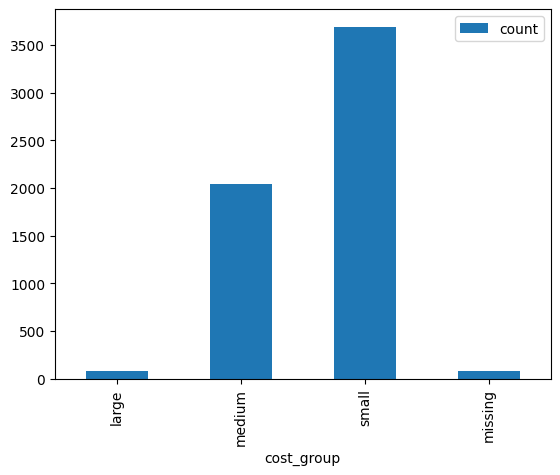

In [7]:
aggregated_pandas_plot = (
    aggregated_pandas.fillna("missing")
    .set_index("cost_group")
    .loc[["large", "medium", "small", "missing"]]
)

aggregated_pandas_plot.plot(kind="bar")

```r
aggregated_r_plot <- aggregated_r %>% dplyr::arrange(desc(cost_group))

ggplot2::ggplot(aggregated_r_plot, ggplot2::aes(cost_group, count)) +
    ggplot2::geom_bar(stat="identity")
```

```{figure} ../images/spark_app_incident_cost_chart.png
---
width: 100%
name: IncidentCostChart
alt: Simple bar chart of animal rescue incident cost by cost group chart
---
Animal rescue incident cost by cost group
```

Now we have our chart, let's see how that translates to tasks in the Spark UI.

There is a job for `.toPandas()`/`collect()`, but nothing after that for the plot. Why? 

The plotting was done in Pandas/R and so Spark was not involved at all. We therefore don't expect the Spark UI to show anything that represents those processes.

### Improving performance

Finally, let's take a look at the stages and tasks for the latest job in the Spark UI and have and see an example of identifying a performance issue, how to solving it, and finding evidence of improvement.

The `.toPandas()`/`collect()` job has two stages because the `.groupBy()`[`.agg()`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.agg.html)/`group_by() %>% `[`summarise()`](https://dplyr.tidyverse.org/reference/summarise.html) command is a wide transformation. In the first stage the data is read in, a new column added and then the dataset is aggregated. This stage has 2 tasks because the `rescue` DataFrame has 2 partitions. The second stage in this job moves the data from the cluster to the CDSW session. This stage has 200 tasks, because `aggregated_spark` has 200 partitions, more on why this is the case in the [Partitions](../spark-concepts/partitions). A screenshot of the *Stage details* for these tasks is below.

```{figure} ../images/spark_app_200_tasks.png
---
width: 100%
name: TaskInfo200
alt: Task information, such as processing time and scheduling time, showing relatively poor performance due to over-partitioning a small DataFrame
---
Task information showing relatively poor performance
```

As we're running in local mode with 2 cores (or threads), the processing of these 200 tasks took place on the driver. The tasks seem to show relatively poor performance, which is indicated by the non-green colours in the timeline. Also by comparing the *Duration* (useful processing time) metrics with that of *Scheduler Delay* and *Task Deserialization Time* in the *Summary Metrics* table. Would we get better performance if the `aggregated_spark` DataFrame had fewer partitions? Let's try to improve the performance by reducing the number of partitions from 200 to 2 with [`.coalesce()`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.coalesce.html)/[`sdf_coalesce()`](https://spark.rstudio.com/packages/sparklyr/latest/reference/sdf_coalesce.html):

In [8]:
aggregated_spark = rescue.groupBy("cost_group").agg(F.count("incident_number").alias("count")).coalesce(2)
aggregated_pandas = aggregated_spark.toPandas()

```r
aggregated_spark <- rescue %>% 
    dplyr::group_by(cost_group) %>%
    dplyr::summarise(count=n()) %>%
    sparklyr::sdf_coalesce(2)

                                    
aggregated_r <- aggregated_spark %>% 
    sparklyr::collect()
```

Now navigate to the details of the latter stage of the latest job within the UI and you will see something similar to the screenshot below. Of course, the all important metric to compare is the time taken to complete the stage. Previously, using 200 partitions the stage time was 0.6 seconds, using 2 partitions the stage time was 0.3 seconds. Looking at this page we can see why.

```{figure} ../images/spark_app_2_tasks.png
---
width: 100%
name: TaskInfo2
alt: Task timeline for processing fewer (but larger) partitions and hence fewer tasks, showing improved performance
---
Task information showing improved performance
```

Note that a 0.3s improvement is nothing to brag about, but a x2 processing speed isn't bad.

Again, the processing took place on the driver with 2 cores, but this time there was one task per core. There's much more green visible in this timeline and comparing *Scheduler Delay* and *Task Deserialization Time* with *Duration* in the *Summary Metrics* tells a very different story.

The important point is that we are processing a small amount of data and therefore should reduce the partitioning. With 200 partitions a lot of time was spent scheduling tasks and (de)serializing data. By putting our small DataFrame into fewer partitions we spent more time on useful processing and decreased the overall processing time.

### Summary

**Spark application hierarchy**

    - Application 
        - Job 
            - Stage 
                - Task


**Use the Spark UI to**
- debug slow or crashing applications
- investigate what Spark is doing "under the hood"


**Tips**
- Look out for task colours, green is generally good
- Use online documentation for more information about the UI
- Lots of small partitions is an inefficient strategy to process data
- Matching up the executed code with the job number in the UI is difficult, the description starts with the action used to initiate that job. You can also customise the job description to track jobs easier. See the article on [Set Spark Job Description](../spark-functions/job-description) for more information.

### Further Resources

Spark at the ONS Articles:
- [Partitions](../spark-concepts/partitions)
- [Shuffling](../spark-concepts/shuffling)
- [Persisting](../spark-concepts/persistence)
- [Optimising Joins](../spark-concepts/join-concepts)
- [Garbage Collection](../spark-concepts/garbage-collection)
- [Set Spark Job Description](../spark-functions/job-description) 

PySpark Documentation:
- [`SparkSession`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.SparkSession.html)
- [`.count()`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.count.html)
- [`.groupBy()`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.groupBy.html)
- [`.join()`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.join.html)
- [`spark.stop()`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.SparkSession.stop.html)
- [`.show()`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.show.html)
- [`.toPandas()`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.toPandas.html)
- [`.agg()`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.agg.html)
- [`.coalesce()`](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.coalesce.html)

sparklyr and tidyverse Documentation:
- [`spark_connect()` and `spark_disconnect()`](https://spark.rstudio.com/packages/sparklyr/latest/reference/spark-connections.html)
- [`group_by()`](https://dplyr.tidyverse.org/reference/group_by.html)
- [`left_join()`](https://spark.rstudio.com/packages/sparklyr/latest/reference/join.tbl_spark.html)
- [`sdf_nrow()`](https://spark.rstudio.com/packages/sparklyr/latest/reference/sdf_dim.html)
- [`collect()`](https://dplyr.tidyverse.org/reference/compute.html)
- [`summarise()`](https://dplyr.tidyverse.org/reference/summarise.html)
- [`sdf_coalesce()`](https://spark.rstudio.com/packages/sparklyr/latest/reference/sdf_coalesce.html)

Spark documentation:
- [Monitoring and Instrumentation](https://spark.apache.org/docs/latest/monitoring.html)
- [Spark Web UI](https://spark.apache.org/docs/latest/web-ui.html)